In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from random import seed
from random import random
import numbers
import sys, string, os
from mpl_toolkits import mplot3d

import lal, lalsimulation
from lalsimulation import SimInspiralTransformPrecessingNewInitialConditions
from lalsimulation import SimInspiralTransformPrecessingWvf2PE
from lalsimulation import SimIMRPhenomPCalculateModelParametersFromSourceFrame
from lal import MSUN_SI, G_SI, C_SI

#-pycbc--------
import pycbc
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import highpass_fir, matched_filter
from pycbc.detector import Detector
import pycbc.noise
from pycbc.noise import noise_from_psd

from pycbc.types import FrequencySeries, TimeSeries, zeros, real_same_precision_as
from pycbc import pnutils
from pycbc.pnutils import f_SchwarzISCO as ISCO
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types.timeseries import TimeSeries
from pycbc.filter import match
from pycbc.filter.matchedfilter import overlap_cplx


#---module related to harmonics waveforms---
from harmonics_waveforms import * 
from conversions import *
from plot_fun import *

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
noise_switch = 1
d_eff_inj = 500       # Effective distance

In [3]:
flow = 20
fref = flow

In [4]:
def Tot_mass_to_Comp_mass(M, q):
    m1 = M * q / (1 + q)
    m2 = M * 1. / (1 + q)
    
    return m1, m2

In [5]:
#masses
M_inj = 48.
q_inj = 6.

# spins and orientations            
cp_inj = 0.6
ce_inj = 0.2

In [6]:
m1_inj, m2_inj = Tot_mass_to_Comp_mass(M_inj, q_inj)
print(m1_inj, m2_inj)

41.142857142857146 6.857142857142857


In [7]:
mchirp_inj, eta_inj = pycbc.pnutils.mass1_mass2_to_mchirp_eta(m1_inj, m2_inj)
print(mchirp_inj, eta_inj)

13.614896355561992 0.12244897959183675


In [8]:
rng = np.random.RandomState(0)
chip_inj = cp_inj
chi_eff_inj = ce_inj
phi0 = rng.random()
theta_JN = rng.random()
phi_JL = rng.random()
print(phi0, theta_JN, phi_JL)

0.5488135039273248 0.7151893663724195 0.6027633760716439


In [9]:
chi1 = np.sqrt(chip_inj**2 + chi_eff_inj**2)
theta1 = np.arctan2(chip_inj, chi_eff_inj)
print(chi1, theta1)

0.6324555320336759 1.2490457723982544


In [10]:
inc_inj, s1x_inj, s1y_inj, s1z_inj, s2x_inj, s2y_inj, s2z_inj = \
        SimInspiralTransformPrecessingNewInitialConditions(theta_JN, phi_JL,
                theta1, 0., # spin orientations
                0., # angle between spins
                chi1, 0.,# spin magnitudes
                m1_inj*MSUN_SI, m2_inj*MSUN_SI, flow, phi0)

In [11]:
print(s1x_inj, s1y_inj, s1z_inj)
print(s2x_inj, s2y_inj, s2z_inj)
print(np.sqrt(s1x_inj**2 + s1y_inj**2 + s1z_inj**2), np.sqrt(s2x_inj**2 + s2y_inj**2 + s2z_inj**2))

-0.4515609338578665 0.39508571603313075 0.2
0.0 0.0 0.0
0.632455532033676 0.0


In [12]:
def chi_prec(mass1, mass2, spin1x, spin1y, spin2x, spin2y):
    """Return chi_p given samples for mass1, mass2, spin1x, spin1y, spin2x,
    spin2y
    """
    mass_ratio = mass2 / mass1
    S1_perp = ((spin1x)**2 + (spin1y)**2)**0.5
    S2_perp = ((spin2x)**2 + (spin2y)**2)**0.5
    chi_p = np.maximum(
        S1_perp, (4 * mass_ratio + 3) / (3 * mass_ratio + 4) * mass_ratio
        * S2_perp
    )
    return chi_p

In [13]:
def chi_effective(mass1, mass2, spin1z, spin2z):
    """Return chi_eff given samples for mass1, mass2, spin1z, spin2z
    """
    return (spin1z * mass1 + spin2z * mass2) / (mass1 + mass2)

In [14]:
chip_i = chi_prec(m1_inj, m2_inj, s1x_inj, s1y_inj, s2x_inj, s2y_inj)
print(chip_inj, chip_i)

0.6 0.6000000000000001


In [15]:
chi_eff_i = chi_effective(m1_inj, m2_inj, s1z_inj, s2z_inj)
print(chi_eff_inj, chi_eff_i)

0.2 0.17142857142857146


In [16]:
apx = 'IMRPhenomPv2'
fhigh = 2048.
fSamp = 2*fhigh
dt = 1.0/fSamp

In [17]:
sp, sc = get_td_waveform(approximant = apx, mass1 = m1_inj, mass2 = m2_inj, 
                                    spin1x = s1x_inj, spin1y = s1y_inj, spin1z = s1z_inj, 
                                    spin2x = s2x_inj, spin2y = s2y_inj, spin2z = s2z_inj, 
                                    inclination = inc_inj, coa_phase = phi0, distance = d_eff_inj,
                                    f_lower = flow, f_final = fhigh, delta_t = dt)

In [18]:
print(len(sp), len(sc))

32768 32768


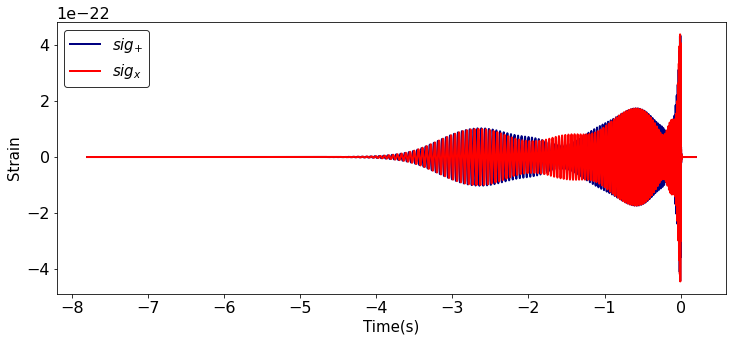

In [19]:
plt.figure(figsize = (12, 5))
plt.plot(sp.sample_times, sp.data, 'navy', label = r'$sig_{+}$')
plt.plot(sc.sample_times, sc.data, 'red', label = r'$sig_{x}$')
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.xlabel('Time(s)', fontsize = 15)
plt.ylabel('Strain', fontsize = 15)
plt.show()

In [20]:
T = int(len(sp)/fSamp)
print(T)
ta = int(T/2) + 1.5
print (ta)

8
5.5


In [21]:
N = int(T*fSamp)
N_ta = int(ta*fSamp)
print(N, N_ta)

32768 22528


In [22]:
t = np.linspace(0, T, N)
f = np.linspace(0,int(fSamp/2), int(N/2)+1)
df = 1.0/T
print(df)

0.125


In [23]:
ra = 1.375
dec = -1.2108
psi_J = np.pi/3
t_gps = 0.
detector = 'H1'
det = Detector(detector)
fp, fc = det.antenna_pattern(ra, dec, psi_J, t_gps)
print(fp, fc)

0.2232456941190503 -0.7035253548675515


In [24]:
s = TimeSeries(zeros(len(sp)), delta_t = sp.delta_t)
s.data = fp*sp.data + fc*sc.data

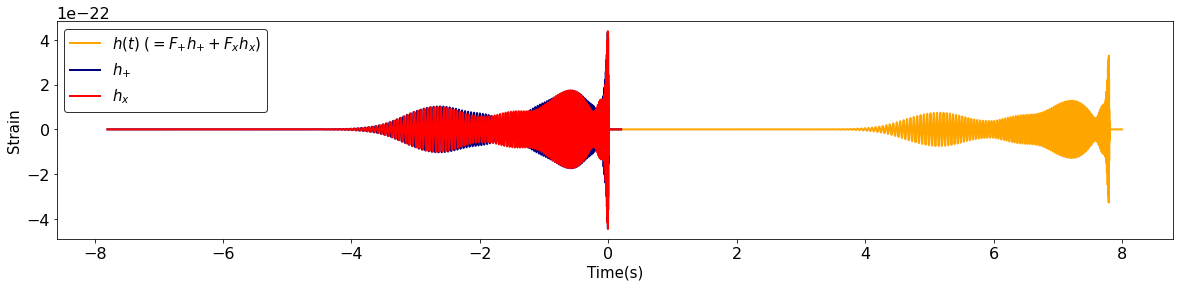

In [25]:
plt.figure(figsize = (20, 4))
plt.plot(s.sample_times, s.data, 'orange', label = r'$h(t) \ ( = F_{+}h_{+} + F_{x}h_{x})$')
plt.plot(sp.sample_times, sp.data, 'navy', label = r'$h_{+}$')
plt.plot(sc.sample_times, sc.data, 'red', label = r'$h_{x}$')
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.xlabel('Time(s)', fontsize = 15)
plt.ylabel('Strain', fontsize = 15)
plt.show()

In [26]:
signal = np.roll(s.data, N_ta)
signal = TimeSeries(signal, delta_t = dt)

In [27]:
##PSD
psd = aLIGOZeroDetHighPower(int(N/2) + 1, df, flow)  

#Generate colored Gaussian noise
nt = pycbc.noise.noise_from_psd(N, dt, psd, seed = 127)

In [28]:
print (2*len(psd))
print (N, len(signal))

32770
32768 32768


In [29]:
data = TimeSeries(zeros(N, real_same_precision_as(nt)), dt)
data.data = noise_switch*nt.data + signal.data

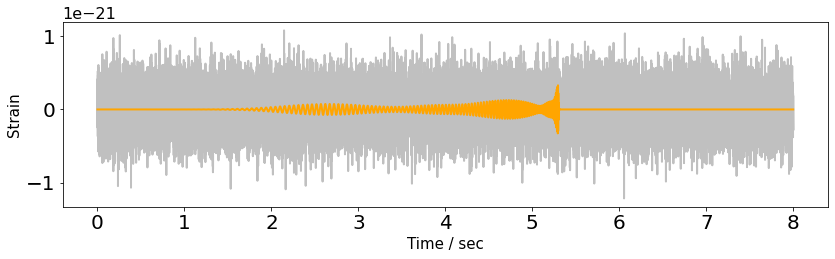

In [30]:
plt.figure(figsize = (12, 4))
plt.plot(data.sample_times, data.data,'silver')
plt.plot(signal.sample_times, signal.data, 'orange')
plt.xlabel('Time / sec', fontsize = 15)
plt.ylabel('Strain', fontsize = 15)
plt.tick_params(labelsize = 20, bottom = True, labelbottom = True)
plt.grid(False)
plt.tight_layout()
plt.show()

In [31]:
snr_p = matched_filter(sp, data, psd = psd, low_frequency_cutoff = flow)

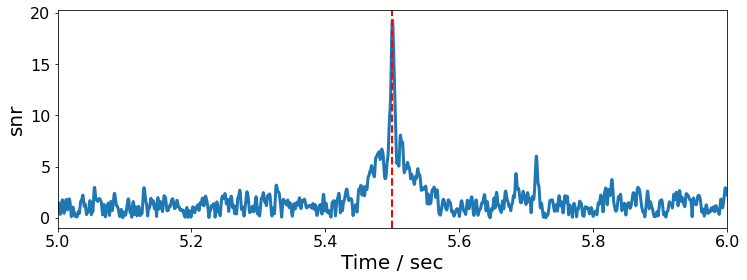

In [32]:
a1 = .5
b1 = .5
plt.figure(figsize = (12, 4))
plt.plot(t, abs(snr_p), '-', lw = 3)
plt.axvline(x = ta, linestyle = '--', color = 'r', lw = 2)
plt.xlabel('Time / sec')
plt.ylabel('snr')
plt.xlim([ta - a1, ta + b1])
plt.show()

In [33]:
hpt_a, hct_a = get_td_waveform(approximant = apx, mass1 = m1_inj, mass2 = m2_inj, spin1z = s1z_inj, spin2z = s2z_inj, 
                                    inclination = inc_inj, coa_phase = phi0, distance = 1.,
                                    f_lower = flow, delta_t = dt)

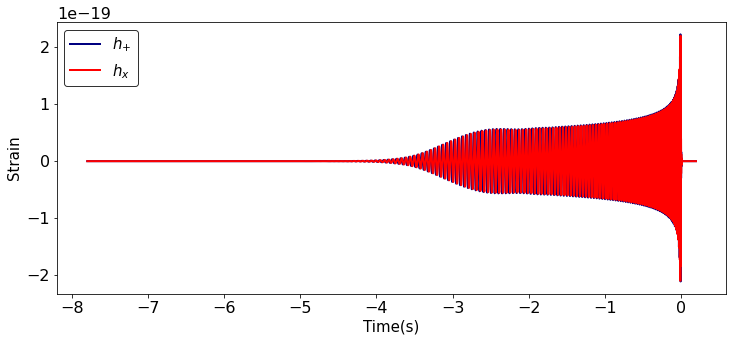

In [34]:
plt.figure(figsize = (12, 5))
plt.plot(hpt_a.sample_times, hpt_a.data, 'navy', label = r'$h_{+}$')
plt.plot(hct_a.sample_times, hct_a.data, 'red', label = r'$h_{x}$')
#plt.xlim(-100, 0)
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.xlabel('Time(s)', fontsize = 15)
plt.ylabel('Strain', fontsize = 15)
plt.show()

In [35]:
snr_a1 = matched_filter(hpt_a, data, psd = psd, low_frequency_cutoff = flow)

<Figure size 864x288 with 0 Axes>

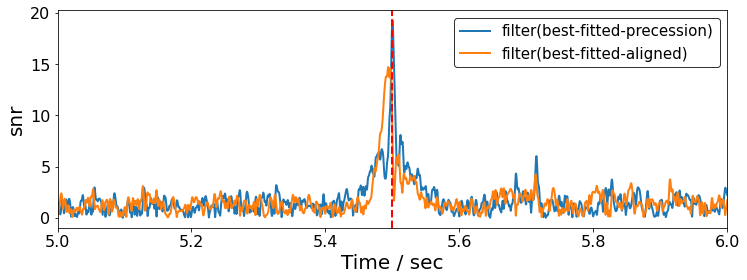

In [36]:
plt.figure(figsize = (12, 4))
a1 = 0.5
b1 = 0.5
j = 9
plt.figure(figsize = (12, 4))
plt.plot(t, abs(snr_p), lw = 2, label = 'filter(best-fitted-precession)')
plt.plot(t, abs(snr_a1), lw = 2, label = 'filter(best-fitted-aligned)')
plt.axvline(x = ta, linestyle = '--', color = 'r', lw = 2)
plt.xlabel('Time / sec')
plt.ylabel('snr')
plt.xlim([ta - a1, ta + b1])
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.show()

In [37]:
hpf_a, hcf_a = get_fd_waveform(approximant = apx, mass1 = m1_inj, mass2 = m2_inj, spin1z = s1z_inj, spin2z = s2z_inj, 
                              inclination = inc_inj, coa_phase = phi0, distance = 1.,
                              f_lower = flow, f_final = fhigh, delta_f = df)

In [38]:
snr_a2 = matched_filter(hpf_a, data, psd = psd, low_frequency_cutoff = flow)

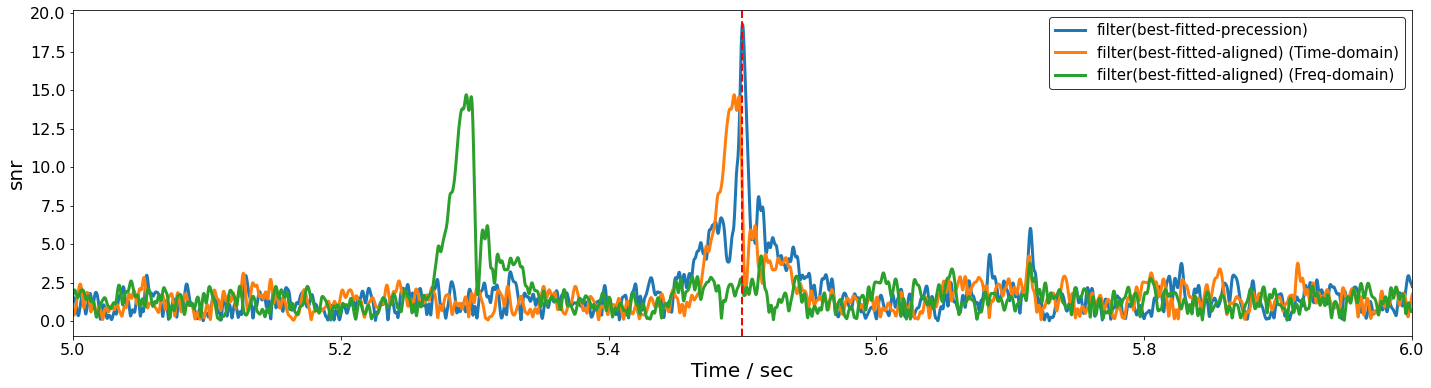

In [39]:
plt.figure(figsize = (24, 6))
a1 = 0.5
b1 = 0.5
j = 9

plt.plot(t, abs(snr_p), lw = 3, label = 'filter(best-fitted-precession)')
plt.plot(t, abs(snr_a1), lw = 3, label = 'filter(best-fitted-aligned) (Time-domain)')
plt.plot(t, abs(snr_a2), lw = 3, label = 'filter(best-fitted-aligned) (Freq-domain)')
plt.axvline(x = ta, linestyle = '--', color = 'r', lw = 2)
plt.xlabel('Time / sec')
plt.ylabel('snr')
plt.xlim([ta - a1, ta + b1])
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.show()

In [40]:
hpt_a_new = hpf_a.to_timeseries()

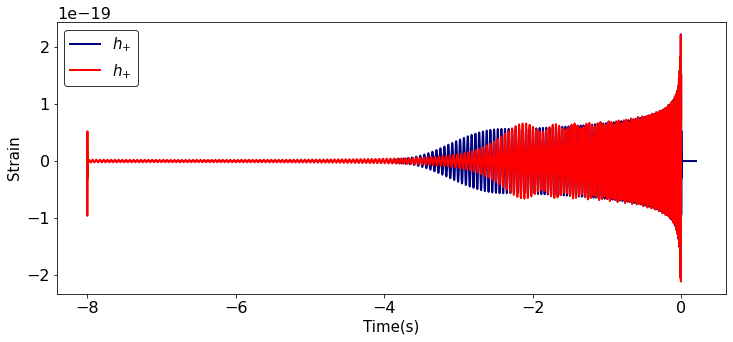

In [41]:
plt.figure(figsize = (12, 5))
plt.plot(hpt_a.sample_times, hpt_a.data, 'navy', label = r'$h_{+}$')
plt.plot(hpt_a_new.sample_times, hpt_a_new.data, 'red', label = r'$h_{+}$')
#plt.xlim(-100, 0)
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.xlabel('Time(s)', fontsize = 15)
plt.ylabel('Strain', fontsize = 15)
plt.show()